# Adversarial Robustness - SVHN
---

In this notebook, the state-of-the-art CNN of 4 convolutional layers prior to the fully-connected part trained on the SVHN dataset "CNN_SVHN" and the best accuracy distillated model "SCNN_MIMIC_SVHN_h64_128_1.5" (pruned & non-pruned) go under the same series of adversarial attacks to compare their "out-of-the-box" adversarial robustness. The adversarial attacks are generated using cleverhans library [Technical Report on the cleverhans v2.1.0 Adversarial Examples Library](https://arxiv.org/pdf/1610.00768.pdf) by Papernot et al. The adversarial attacks tested: 

*   Projected Gradient Descent [Towards deep learning models resistant to adversarial attacks](https://arxiv.org/pdf/1706.06083.pdf) by Madry et al.
*   Basic Iterative Method [Adversarial examples in the physical world](https://arxiv.org/pdf/1607.02533.pdf) by Kurakin et al.
*   Momentum Iterative Method [Boosting adversarial attacks with momentum](https://arxiv.org/pdf/1710.06081.pdf) by Dong et al.


## Load the Neccesary Packages

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
!pip install tensorflow==1.15.0

In [ ]:
import keras
from keras.datasets import mnist
from keras.models import Model
from keras.layers import Dense, Dropout, Flatten ,Input
from keras.layers import Conv2D, MaxPooling2D, Reshape, Add
from keras.metrics import categorical_accuracy
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.layers import Activation
from keras.utils.generic_utils import get_custom_objects
from tensorflow.python.keras import backend as K
from keras.preprocessing.image import array_to_img,img_to_array
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
import keras
from keras import optimizers
from keras.callbacks import ReduceLROnPlateau, EarlyStopping
from keras.models import Model
from keras.layers import Lambda, concatenate, Activation
from keras.losses import categorical_crossentropy as logloss
from keras.metrics import categorical_accuracy, top_k_categorical_accuracy
from keras import backend as K
from keras.applications.mobilenet import preprocess_input
import matplotlib.pyplot as plt
%matplotlib inline
from scipy.special import softmax
from sklearn.model_selection import train_test_split
from keras import models
from keras import layers
from scipy.io import loadmat

In [ ]:
!pip install cleverhans

In [ ]:
session = tf.Session()
session = tf.compat.v1.Session()
keras.backend.set_session(session)

## Attack SVHN - Teacher

### Load Model and Data

In [ ]:
def get_CNN_model():
  #CNN network for classification
  svhn_model = models.Sequential(name='CNN')
  svhn_model.add(layers.Conv2D(32,(3,3),activation='relu', input_shape=(32, 17, 3)))
  svhn_model.add(layers.Conv2D(32,(3,3),activation='relu'))
  svhn_model.add(layers.MaxPool2D(pool_size=(2, 2)))
  svhn_model.add(Dropout(0.3))
  svhn_model.add(layers.Conv2D(64,(3,3),activation='relu'))
  svhn_model.add(layers.Conv2D(64,(3,3),activation='relu'))
  svhn_model.add(layers.MaxPool2D(pool_size=(2, 2)))
  svhn_model.add(Dropout(0.3))
  svhn_model.add(Flatten())
  svhn_model.add(layers.Dense(512, activation='relu'))
  svhn_model.add(Dropout(0.3))
  svhn_model.add(layers.Dense(10,name="logit"))
  svhn_model.add(layers.Activation('softmax'))
  return svhn_model

In [ ]:
# Load the model
svhn_model = get_CNN_model()
svhn_model = keras.models.load_model('/content/drive/My Drive/Colab Notebooks/SVHN/CNN_SVHN.h5')
svhn_model.summary()

In [ ]:
# Restore the data
x_acc_test_cnn=np.load('/content/drive/My Drive/Colab Notebooks/SVHN/data/x_acc_test_cnn.npy')
y_acc_test=np.load('/content/drive/My Drive/Colab Notebooks/SVHN/data/y_acc_test.npy')

### Define the Attacks

In [ ]:
from cleverhans.utils_keras import KerasModelWrapper
from cleverhans.attacks import BasicIterativeMethod
from cleverhans.attacks import ProjectedGradientDescent
from cleverhans.attacks import MomentumIterativeMethod

def bim_attack(svhn_model, epsilon):
  wrap = KerasModelWrapper(svhn_model)
  bim = BasicIterativeMethod(wrap, sess=session)

  bim_params = {'eps': epsilon,
                'eps_iter': 0.5*epsilon,
                'nb_iter': 100,
                'clip_min': 0.,
                'clip_max': 1.}

  adv_x = bim.generate_np(x_acc_test_cnn, **bim_params)
  score, adv_acc = svhn_model.evaluate(adv_x, y_acc_test, batch_size=128)
  print("The BIM validation accuracy is: {}".format(adv_acc))
  return score, adv_acc

def pgd_attack(svhn_model, epsilon):
  wrap = KerasModelWrapper(svhn_model)
  pgd = ProjectedGradientDescent(wrap, sess=session)

  pgd_params = {'eps': epsilon,
                'eps_iter': 0.5*epsilon,
                'nb_iter': 100,
                'clip_min': 0.,
                'clip_max': 1.}

  adv_x = pgd.generate_np(x_acc_test_cnn, **pgd_params)
  score, adv_acc = svhn_model.evaluate(adv_x, y_acc_test, batch_size=128)
  print("The PGD validation accuracy is: {}".format(adv_acc))
  return score, adv_acc

def mim_attack(svhn_model, epsilon):
  wrap = KerasModelWrapper(svhn_model)
  mim = MomentumIterativeMethod(wrap, sess=session)

  mim_params = {'eps': epsilon,
                'eps_iter': 0.5*epsilon,
                'nb_iter': 100,
                'clip_min': 0.,
                'clip_max': 1.}

  adv_x = mim.generate_np(x_acc_test_cnn, **mim_params)
  score, adv_acc = svhn_model.evaluate(adv_x, y_acc_test, batch_size=128)
  print("The MIM validation accuracy is: {}".format(adv_acc))
  return score, adv_acc

### Basic Iterative Method

In [ ]:
epsilon_accuracies_teacher_bim = []
epsilon_values_teacher_bim = []

# Load the model and wrap the network
svhn_model = get_CNN_model()
svhn_model = keras.models.load_model('/content/drive/My Drive/Colab Notebooks/SVHN/CNN_SVHN.h5')
score, acc = svhn_model.evaluate(x_acc_test_cnn, y_acc_test, batch_size=128)
print ("Test Accuracy: %.5f" % acc)

for epsilon in np.arange(0.0, 0.1, 0.01):
  score, adv_acc = bim_attack(svhn_model, epsilon)
  epsilon_accuracies_teacher_bim.append(adv_acc)
  epsilon_values_teacher_bim.append(epsilon)

for epsilon in np.arange(0.1, 0.3, 0.1):
  score, adv_acc = bim_attack(svhn_model, epsilon)
  epsilon_accuracies_teacher_bim.append(adv_acc)
  epsilon_values_teacher_bim.append(epsilon)

plt.xlabel('Epsilon');
plt.ylabel('Accuracy After Attack');
plt.plot(epsilon_values_teacher_bim, epsilon_accuracies_teacher_bim)

print (epsilon_accuracies_teacher_bim)
print (epsilon_values_teacher_bim)

### Projected Gradient Descent

In [ ]:
epsilon_accuracies_teacher_pgd = []
epsilon_values_teacher_pgd  = []

# Load the model and wrap the network
svhn_model = get_CNN_model()
svhn_model = keras.models.load_model('/content/drive/My Drive/Colab Notebooks/SVHN/CNN_SVHN.h5')
score, acc = svhn_model.evaluate(x_acc_test_cnn, y_acc_test, batch_size=128)
print ("Test Accuracy: %.5f" % acc)

for epsilon in np.arange(0.0, 0.1, 0.001):
  score, adv_acc = pgd_attack(svhn_model, epsilon)
  epsilon_accuracies_teacher_pgd.append(adv_acc)
  epsilon_values_teacher_pgd.append(epsilon)

for epsilon in np.arange(0.1, 0.3, 0.1):
  score, adv_acc = pgd_attack(svhn_model, epsilon)
  epsilon_accuracies_teacher_pgd.append(adv_acc)
  epsilon_values_teacher_pgd.append(epsilon)

plt.xlabel('Epsilon');
plt.ylabel('Accuracy After Attack');
plt.plot(epsilon_values_teacher_pgd, epsilon_accuracies_teacher_pgd)

print (epsilon_accuracies_teacher_pgd)
print (epsilon_values_teacher_pgd)

### Momentum Iterative Method

In [ ]:
epsilon_accuracies_teacher_mim = []
epsilon_values_teacher_mim = []

# Load the model and wrap the network
svhn_model = get_CNN_model()
svhn_model = keras.models.load_model('/content/drive/My Drive/Colab Notebooks/SVHN/CNN_SVHN.h5')
score, acc = svhn_model.evaluate(x_acc_test_cnn, y_acc_test, batch_size=128)
print ("Test Accuracy: %.5f" % acc)

for epsilon in np.arange(0.0, 0.1, 0.01):
  score, adv_acc = mim_attack(svhn_model, epsilon)
  epsilon_accuracies_teacher_mim.append(adv_acc)
  epsilon_values_teacher_mim.append(epsilon)

for epsilon in np.arange(0.1, 0.3, 0.1):
  score, adv_acc = mim_attack(svhn_model, epsilon)
  epsilon_accuracies_teacher_mim.append(adv_acc)
  epsilon_values_teacher_mim.append(epsilon)

plt.xlabel('Epsilon');
plt.ylabel('Accuracy After Attack');
plt.plot(epsilon_values_teacher_mim, epsilon_accuracies_teacher_mim)

print (epsilon_accuracies_teacher_mim)
print (epsilon_values_teacher_mim)

## Attack SVHN - Best Student

### Load Model and Data

In [ ]:
def get_SCNN_model_layer2(channels_l1, channels_l2):
  #CNN network for classification
  svhn_model = models.Sequential(name='SCNN')
  svhn_model.add(layers.Conv2D(channels_l1,(3,3),activation='relu', input_shape=(32, 17, 3)))
  svhn_model.add(layers.MaxPool2D(pool_size=(2, 2)))
  svhn_model.add(layers.Conv2D(channels_l2,(3,3),activation='relu'))
  svhn_model.add(layers.MaxPool2D(pool_size=(2, 2)))
  svhn_model.add(Flatten())
  svhn_model.add(layers.Dense(512, activation='relu'))
  svhn_model.add(layers.Dense(10,name="logit"))
  svhn_model.add(layers.Activation('softmax'))
  return svhn_model

In [ ]:
# Load the model
svhn_model = get_SCNN_model_layer2(channels_l1=64, channels_l2=128)
svhn_model = keras.models.load_model('/content/drive/My Drive/Colab Notebooks/SVHN/SCNN_MIMIC_SVHN_h64_128_1.5.h5')
svhn_model.summary()

In [ ]:
# Restore the data
x_acc_test_cnn=np.load('/content/drive/My Drive/Colab Notebooks/SVHN/data/x_acc_test_cnn.npy')
y_acc_test=np.load('/content/drive/My Drive/Colab Notebooks/SVHN/data/y_acc_test.npy')

### Define the Attacks

In [ ]:
from cleverhans.utils_keras import KerasModelWrapper
from cleverhans.attacks import BasicIterativeMethod
from cleverhans.attacks import ProjectedGradientDescent
from cleverhans.attacks import MomentumIterativeMethod

def bim_attack(svhn_model, epsilon):
  wrap = KerasModelWrapper(svhn_model)
  bim = BasicIterativeMethod(wrap, sess=session)

  bim_params = {'eps': epsilon,
                'eps_iter': 0.5*epsilon,
                'nb_iter': 100,
                'clip_min': 0.,
                'clip_max': 1.}

  adv_x = bim.generate_np(x_acc_test_cnn, **bim_params)
  score, adv_acc = svhn_model.evaluate(adv_x, y_acc_test, batch_size=128)
  print("The BIM validation accuracy is: {}".format(adv_acc))
  return score, adv_acc

def pgd_attack(svhn_model, epsilon):
  wrap = KerasModelWrapper(svhn_model)
  pgd = ProjectedGradientDescent(wrap, sess=session)

  pgd_params = {'eps': epsilon,
                'eps_iter': 0.5*epsilon,
                'nb_iter': 100,
                'clip_min': 0.,
                'clip_max': 1.}

  adv_x = pgd.generate_np(x_acc_test_cnn, **pgd_params)
  score, adv_acc = svhn_model.evaluate(adv_x, y_acc_test, batch_size=128)
  print("The PGD validation accuracy is: {}".format(adv_acc))
  return score, adv_acc

def mim_attack(svhn_model, epsilon):
  wrap = KerasModelWrapper(svhn_model)
  mim = MomentumIterativeMethod(wrap, sess=session)

  mim_params = {'eps': epsilon,
                'eps_iter': 0.5*epsilon,
                'nb_iter': 100,
                'clip_min': 0.,
                'clip_max': 1.}

  adv_x = mim.generate_np(x_acc_test_cnn, **mim_params)
  score, adv_acc = svhn_model.evaluate(adv_x, y_acc_test, batch_size=128)
  print("The MIM validation accuracy is: {}".format(adv_acc))
  return score, adv_acc

### Basic Iterative Method

In [ ]:
epsilon_accuracies_student_bim = []
epsilon_values_student_bim = []

# Load the model and wrap the network
svhn_model = get_SCNN_model_layer2(channels_l1=64, channels_l2=128)
svhn_model = keras.models.load_model('/content/drive/My Drive/Colab Notebooks/SVHN/SCNN-MIMIC-SVHN-h64-128_1.5_new')
score, acc = svhn_model.evaluate(x_acc_test_cnn, y_acc_test, batch_size=128)
print ("Test Accuracy: %.5f" % acc)

for epsilon in np.arange(0.0, 0.1, 0.01):
  score, adv_acc = bim_attack(svhn_model, epsilon)
  epsilon_accuracies_student_bim.append(adv_acc)
  epsilon_values_student_bim.append(epsilon)

for epsilon in np.arange(0.1, 0.3, 0.1):
  score, adv_acc = bim_attack(svhn_model, epsilon)
  epsilon_accuracies_student_bim.append(adv_acc)
  epsilon_values_student_bim.append(epsilon)

plt.xlabel('Epsilon');
plt.ylabel('Accuracy After Attack');
plt.plot(epsilon_values_student_bim, epsilon_accuracies_student_bim)

print (epsilon_accuracies_student_bim)
print (epsilon_values_student_bim)

### Projected Gradient Descent

In [ ]:
epsilon_accuracies_student_pgd = []
epsilon_values_student_pgd  = []

# Load the model and wrap the network
svhn_model = get_SCNN_model_layer2(channels_l1=64, channels_l2=128)
svhn_model = keras.models.load_model('/content/drive/My Drive/Colab Notebooks/SVHN/SCNN_MIMIC_SVHN_h64_128_1.5.h5')
#svhn_model = keras.models.load_model('/content/drive/My Drive/Colab Notebooks/SVHN/SCNN-MIMIC-SVHN-h64-128_1.5_new')
score, acc = svhn_model.evaluate(x_acc_test_cnn, y_acc_test, batch_size=128)
print ("Test Accuracy: %.5f" % acc)

for epsilon in np.arange(0.0, 0.1, 0.001):
  score, adv_acc = pgd_attack(svhn_model, epsilon)
  epsilon_accuracies_student_pgd.append(adv_acc)
  epsilon_values_student_pgd.append(epsilon)

for epsilon in np.arange(0.1, 0.3, 0.1):
  score, adv_acc = pgd_attack(svhn_model, epsilon)
  epsilon_accuracies_student_pgd.append(adv_acc)
  epsilon_values_student_pgd.append(epsilon)

plt.xlabel('Epsilon');
plt.ylabel('Accuracy After Attack');
plt.plot(epsilon_values_student_pgd, epsilon_accuracies_student_pgd)

print (epsilon_accuracies_student_pgd)
print (epsilon_values_student_pgd)

### Momentum Iterative Method

In [ ]:
epsilon_accuracies_student_mim = []
epsilon_values_student_mim = []

# Load the model and wrap the network
svhn_model = get_SCNN_model_layer2(channels_l1=64, channels_l2=128)
svhn_model = keras.models.load_model('/content/drive/My Drive/Colab Notebooks/SVHN/SCNN-MIMIC-SVHN-h64-128_1.5_new')
score, acc = svhn_model.evaluate(x_acc_test_cnn, y_acc_test, batch_size=128)
print ("Test Accuracy: %.5f" % acc)

for epsilon in np.arange(0.0, 0.1, 0.01):
  score, adv_acc = mim_attack(svhn_model, epsilon)
  epsilon_accuracies_student_mim.append(adv_acc)
  epsilon_values_student_mim.append(epsilon)

for epsilon in np.arange(0.1, 0.3, 0.1):
  score, adv_acc = mim_attack(svhn_model, epsilon)
  epsilon_accuracies_student_mim.append(adv_acc)
  epsilon_values_student_mim.append(epsilon)

plt.xlabel('Epsilon');
plt.ylabel('Accuracy After Attack');
plt.plot(epsilon_values_student_mim, epsilon_accuracies_student_mim)

print (epsilon_accuracies_student_mim)
print (epsilon_values_student_mim)

## Results

### Basic Iterative Method

In [ ]:
epsilon_accuracies_teacher_bim=[0.9252842664718628, 0.5152504444122314, 0.20390288531780243, 0.0931161642074585, 0.054279349744319916, 0.03956668823957443, 0.03361247852444649, 0.03027043677866459, 0.027735095471143723, 0.026160109788179398, 0.024930855259299278, 0.018554087728261948]
epsilon_values_teacher_bim=[0.0, 0.01, 0.02, 0.03, 0.04, 0.05, 0.06, 0.07, 0.08, 0.09, 0.1, 0.2]
epsilon_accuracies_student_bim=[0.9230562448501587, 0.5165181159973145, 0.19452981650829315, 0.08116932958364487, 0.045789796859025955, 0.03426551818847656, 0.030385678634047508, 0.027850337326526642, 0.026429010555148125, 0.025122925639152527, 0.024546712636947632, 0.017747387290000916]
epsilon_values_student_bim=[0.0, 0.01, 0.02, 0.03, 0.04, 0.05, 0.06, 0.07, 0.08, 0.09, 0.1, 0.2]

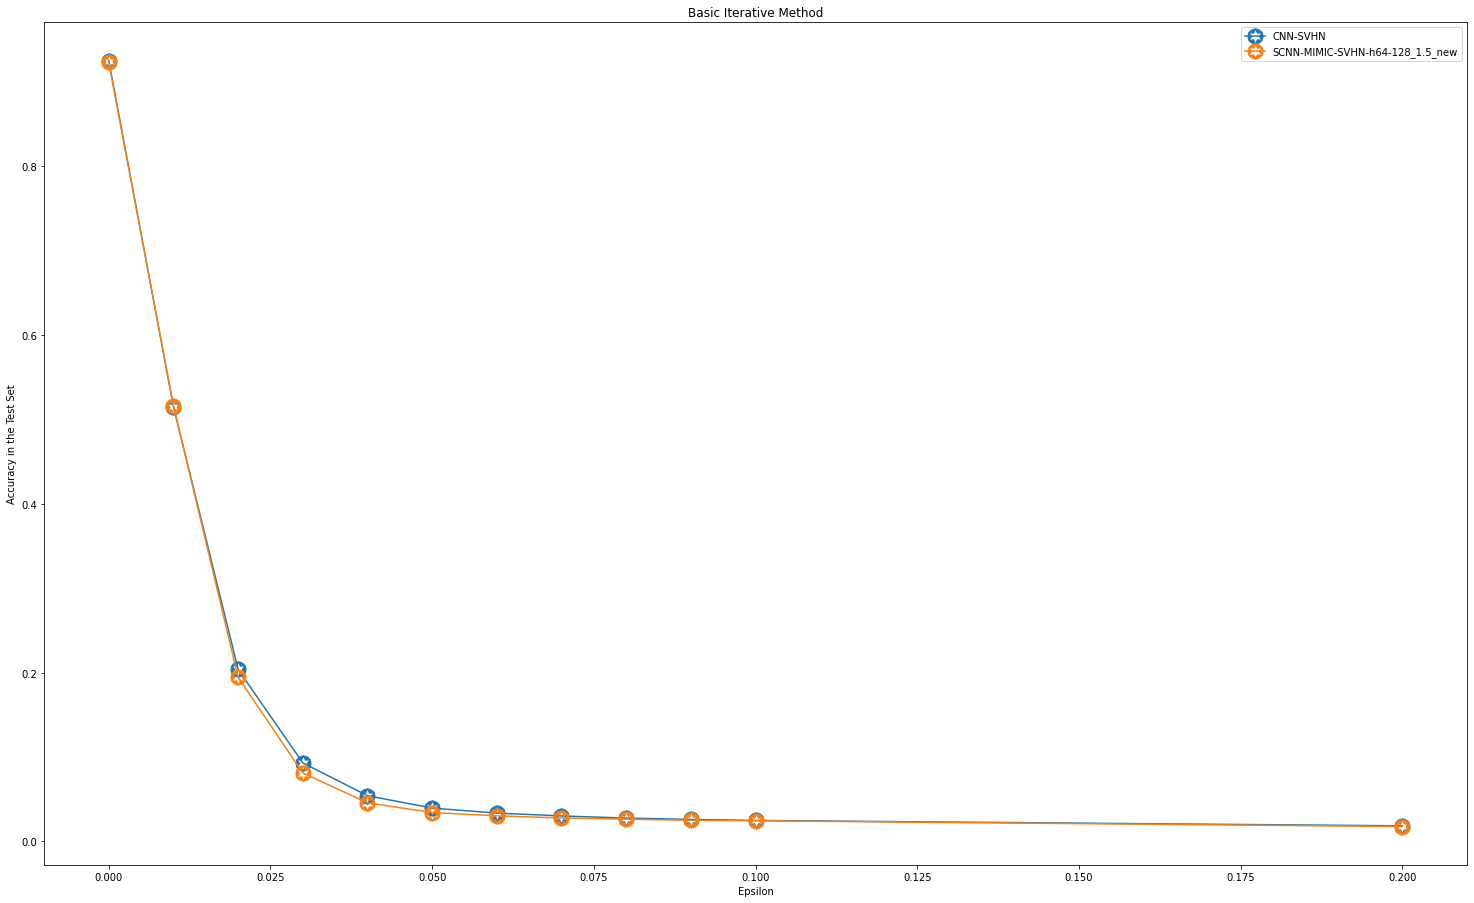

In [ ]:
import matplotlib.path as mpath
import numpy as np

star = mpath.Path.unit_regular_star(6)
circle = mpath.Path.unit_circle()
# concatenate the circle with an internal cutout of the star
verts = np.concatenate([circle.vertices, star.vertices[::-1, ...]])
codes = np.concatenate([circle.codes, star.codes])
cut_star = mpath.Path(verts, codes)

fig = plt.figure()
fig.set_size_inches(25.5, 15.5)

plt.plot(epsilon_values_teacher_bim, epsilon_accuracies_teacher_bim, label='CNN-SVHN', marker=cut_star, markersize=15)
plt.plot(epsilon_values_student_bim, epsilon_accuracies_student_bim, label='SCNN-MIMIC-SVHN-h64-128_1.5_new', marker=cut_star, markersize=15)

plt.title('Basic Iterative Method')
plt.xlabel('Epsilon');
plt.ylabel('Accuracy in the Test Set');
plt.legend()
plt.show()

### Projected Gradient Descent

In [ ]:
epsilon_accuracies_teacher_pgd = [0.9252842664718628, 0.5161339640617371, 0.20459434390068054, 0.0941917672753334, 0.05516287684440613, 0.03879840299487114, 0.03311309218406677, 0.02904118038713932, 0.027120467275381088, 0.02477719821035862, 0.02477719821035862, 0.015673017129302025]
epsilon_values_teacher_pgd = [0.0, 0.01, 0.02, 0.03, 0.04, 0.05, 0.06, 0.07, 0.08, 0.09, 0.1, 0.2]
epsilon_accuracies_student_pgd = [0.9230562448501587, 0.516940712928772, 0.19529809057712555, 0.08193761855363846, 0.04529041051864624, 0.03253687918186188, 0.028503380715847015, 0.026275353506207466, 0.02481561154127121, 0.023279041051864624, 0.021857714280486107, 0.014213276095688343]
epsilon_values_student_pgd = [0.0, 0.01, 0.02, 0.03, 0.04, 0.05, 0.06, 0.07, 0.08, 0.09, 0.1, 0.2]

In [ ]:
epsilon_accuracies_teacher_pgd=[0.9252842664718628, 0.9160648584365845, 0.8921711444854736, 0.858059287071228, 0.8149585127830505, 0.7675937414169312, 0.715657651424408, 0.6645282506942749, 0.6129763126373291, 0.5633835196495056, 0.5140212178230286, 0.46953749656677246, 0.42716655135154724, 0.3897126615047455, 0.354755699634552, 0.3230639100074768, 0.29383066296577454, 0.26859250664711, 0.24523663520812988, 0.22222648561000824, 0.20401813089847565, 0.1864244043827057, 0.17167332768440247, 0.15795943140983582, 0.14674247801303864, 0.13475722074508667, 0.1244237869977951, 0.11581899225711823, 0.1079440712928772, 0.09972342103719711, 0.09361554682254791, 0.08689305186271667, 0.0821681022644043, 0.07824984937906265, 0.07360172271728516, 0.0704517513513565, 0.06630301475524902, 0.06273048371076584, 0.05950368940830231, 0.05708358809351921, 0.054240934550762177, 0.051206208765506744, 0.04982329532504082, 0.04874769598245621, 0.04636600986123085, 0.044637370854616165, 0.043561771512031555, 0.04237092658877373, 0.04114167019724846, 0.03964351490139961, 0.03918254375457764, 0.03760755807161331, 0.03883681446313858, 0.03637830540537834, 0.03534111753106117, 0.03514904901385307, 0.03453442081809044, 0.03361247852444649, 0.03418869152665138, 0.03357406333088875, 0.032921019941568375, 0.0311539638787508, 0.031960662454366684, 0.031038722023367882, 0.03111555054783821, 0.030500922352075577, 0.03192225098609924, 0.029963122680783272, 0.029886294156312943, 0.029732637107372284, 0.02915642224252224, 0.027696680277585983, 0.028388136997818947, 0.027811923995614052, 0.028426552191376686, 0.027619851753115654, 0.02788875252008438, 0.02811923809349537, 0.02692839503288269, 0.026697909459471703, 0.02681315317749977, 0.026198524981737137, 0.026236938312649727, 0.025583896785974503, 0.02585279569029808, 0.025238167494535446, 0.02573755383491516, 0.02485402673482895, 0.025507068261504173, 0.02470036968588829, 0.02377842739224434, 0.02470036968588829, 0.024469884112477303, 0.02366318367421627, 0.024393055588006973, 0.02481561154127121, 0.024585125967860222, 0.023432698100805283, 0.024085741490125656, 0.022933313623070717, 0.023163799196481705, 0.015480946749448776]
epsilon_values_teacher_pgd=[0.0, 0.001, 0.002, 0.003, 0.004, 0.005, 0.006, 0.007, 0.008, 0.009000000000000001, 0.01, 0.011, 0.012, 0.013000000000000001, 0.014, 0.015, 0.016, 0.017, 0.018000000000000002, 0.019, 0.02, 0.021, 0.022, 0.023, 0.024, 0.025, 0.026000000000000002, 0.027, 0.028, 0.029, 0.03, 0.031, 0.032, 0.033, 0.034, 0.035, 0.036000000000000004, 0.037, 0.038, 0.039, 0.04, 0.041, 0.042, 0.043000000000000003, 0.044, 0.045, 0.046, 0.047, 0.048, 0.049, 0.05, 0.051000000000000004, 0.052000000000000005, 0.053, 0.054, 0.055, 0.056, 0.057, 0.058, 0.059000000000000004, 0.06, 0.061, 0.062, 0.063, 0.064, 0.065, 0.066, 0.067, 0.068, 0.069, 0.07, 0.07100000000000001, 0.07200000000000001, 0.073, 0.074, 0.075, 0.076, 0.077, 0.078, 0.079, 0.08, 0.081, 0.082, 0.083, 0.084, 0.085, 0.08600000000000001, 0.08700000000000001, 0.088, 0.089, 0.09, 0.091, 0.092, 0.093, 0.094, 0.095, 0.096, 0.097, 0.098, 0.099, 0.1, 0.2]
epsilon_accuracies_student_pgd=[0.9230562448501587, 0.9116856455802917, 0.8895590305328369, 0.858712375164032, 0.8180316686630249, 0.7718192934989929, 0.7193838357925415, 0.6691763997077942, 0.615050733089447, 0.5654963254928589, 0.5164797306060791, 0.4712277054786682, 0.42835739254951477, 0.38859865069389343, 0.3509911000728607, 0.31718653440475464, 0.28795328736305237, 0.2599108815193176, 0.2360556274652481, 0.21669483184814453, 0.19472187757492065, 0.17701290547847748, 0.16072526574134827, 0.14735710620880127, 0.1346803903579712, 0.12292563170194626, 0.11293791979551315, 0.10298863053321838, 0.09511370956897736, 0.08800707012414932, 0.08132299035787582, 0.07556084543466568, 0.07022126764059067, 0.06703288108110428, 0.061808545142412186, 0.05808236077427864, 0.05497080460190773, 0.05208973586559296, 0.050053779035806656, 0.04886293783783913, 0.045789796859025955, 0.04406115412712097, 0.04237092658877373, 0.041641056537628174, 0.04002765938639641, 0.038337431848049164, 0.03756914660334587, 0.03680086135864258, 0.034841734915971756, 0.03445759043097496, 0.03372772037982941, 0.03211431950330734, 0.0326521210372448, 0.0311539638787508, 0.03142286464571953, 0.03027043677866459, 0.030001536011695862, 0.029963122680783272, 0.029771050438284874, 0.028618622571229935, 0.028349723666906357, 0.02796558104455471, 0.02792716585099697, 0.028849108144640923, 0.027543023228645325, 0.027581438422203064, 0.027619851753115654, 0.02708205208182335, 0.026236938312649727, 0.02608328126370907, 0.026160109788179398, 0.025391824543476105, 0.025353411212563515, 0.02596803940832615, 0.026352182030677795, 0.024930855259299278, 0.025046097114682198, 0.025391824543476105, 0.025430239737033844, 0.02381684072315693, 0.024008912965655327, 0.02481561154127121, 0.02489244006574154, 0.024085741490125656, 0.02389366924762726, 0.02362477034330368, 0.02354794181883335, 0.024316227063536644, 0.022894898429512978, 0.023317456245422363, 0.022971726953983307, 0.022433927282691002, 0.023202212527394295, 0.022357098758220673, 0.02277965657413006, 0.02162722870707512, 0.021857714280486107, 0.021819299086928368, 0.021319914609193802, 0.0226259995251894, 0.021358327940106392, 0.014098033308982849]
epsilon_values_student_pgd=[0.0, 0.001, 0.002, 0.003, 0.004, 0.005, 0.006, 0.007, 0.008, 0.009000000000000001, 0.01, 0.011, 0.012, 0.013000000000000001, 0.014, 0.015, 0.016, 0.017, 0.018000000000000002, 0.019, 0.02, 0.021, 0.022, 0.023, 0.024, 0.025, 0.026000000000000002, 0.027, 0.028, 0.029, 0.03, 0.031, 0.032, 0.033, 0.034, 0.035, 0.036000000000000004, 0.037, 0.038, 0.039, 0.04, 0.041, 0.042, 0.043000000000000003, 0.044, 0.045, 0.046, 0.047, 0.048, 0.049, 0.05, 0.051000000000000004, 0.052000000000000005, 0.053, 0.054, 0.055, 0.056, 0.057, 0.058, 0.059000000000000004, 0.06, 0.061, 0.062, 0.063, 0.064, 0.065, 0.066, 0.067, 0.068, 0.069, 0.07, 0.07100000000000001, 0.07200000000000001, 0.073, 0.074, 0.075, 0.076, 0.077, 0.078, 0.079, 0.08, 0.081, 0.082, 0.083, 0.084, 0.085, 0.08600000000000001, 0.08700000000000001, 0.088, 0.089, 0.09, 0.091, 0.092, 0.093, 0.094, 0.095, 0.096, 0.097, 0.098, 0.099, 0.1, 0.2]

epsilon_accuracies_student_pgd_nonprune=[0.9230562448501587, 0.9114551544189453, 0.8893285393714905, 0.8589428663253784, 0.8181468844413757, 0.7726644277572632, 0.7201905250549316, 0.6682928800582886, 0.615818977355957, 0.5652273893356323, 0.5168254375457764, 0.4712277054786682, 0.4301244616508484, 0.38890597224235535, 0.35179778933525085, 0.3160725235939026, 0.28676244616508484, 0.25918102264404297, 0.23540258407592773, 0.2143515646457672, 0.19518284499645233, 0.17720498144626617, 0.16110940277576447, 0.14493699371814728, 0.13383528590202332, 0.12292563170194626, 0.11167025566101074, 0.10360325872898102, 0.0947679802775383, 0.08704671263694763, 0.08136139810085297, 0.07552243024110794, 0.07037492096424103, 0.06641825288534164, 0.06173171475529671, 0.05789028853178024, 0.05527811869978905, 0.052358634769916534, 0.05086047947406769, 0.04824830964207649, 0.046826981008052826, 0.043523356318473816, 0.04229409992694855, 0.04179471358656883, 0.039413031190633774, 0.03887522965669632, 0.037223417311906815, 0.03637830540537834, 0.03622464835643768, 0.03426551818847656, 0.03349723294377327, 0.03368930518627167, 0.032921019941568375, 0.03142286464571953, 0.03111555054783821, 0.030539335682988167, 0.03015519306063652, 0.029809465631842613, 0.02911800891160965, 0.028657037764787674, 0.029271665960550308, 0.028464965522289276, 0.029386907815933228, 0.027197295799851418, 0.028196066617965698, 0.027466194704174995, 0.026429010555148125, 0.027312537655234337, 0.027389366179704666, 0.02692839503288269, 0.026505839079618454, 0.025276582688093185, 0.025507068261504173, 0.025276582688093185, 0.025199754163622856, 0.02581438235938549, 0.025353411212563515, 0.02496926859021187, 0.024508297443389893, 0.025122925639152527, 0.024393055588006973, 0.024431468918919563, 0.024008912965655327, 0.023394284769892693, 0.02385525591671467, 0.02354794181883335, 0.02381684072315693, 0.024047326296567917, 0.022280270233750343, 0.023086970672011375, 0.022856485098600388, 0.022856485098600388, 0.02277965657413006, 0.023163799196481705, 0.02274124138057232, 0.023240627720952034, 0.022433927282691002, 0.02174247056245804, 0.022241856902837753, 0.021857714280486107, 0.021089429035782814, 0.014482175931334496]
epsilon_values_student_pgd_nonprune=[0.0, 0.001, 0.002, 0.003, 0.004, 0.005, 0.006, 0.007, 0.008, 0.009000000000000001, 0.01, 0.011, 0.012, 0.013000000000000001, 0.014, 0.015, 0.016, 0.017, 0.018000000000000002, 0.019, 0.02, 0.021, 0.022, 0.023, 0.024, 0.025, 0.026000000000000002, 0.027, 0.028, 0.029, 0.03, 0.031, 0.032, 0.033, 0.034, 0.035, 0.036000000000000004, 0.037, 0.038, 0.039, 0.04, 0.041, 0.042, 0.043000000000000003, 0.044, 0.045, 0.046, 0.047, 0.048, 0.049, 0.05, 0.051000000000000004, 0.052000000000000005, 0.053, 0.054, 0.055, 0.056, 0.057, 0.058, 0.059000000000000004, 0.06, 0.061, 0.062, 0.063, 0.064, 0.065, 0.066, 0.067, 0.068, 0.069, 0.07, 0.07100000000000001, 0.07200000000000001, 0.073, 0.074, 0.075, 0.076, 0.077, 0.078, 0.079, 0.08, 0.081, 0.082, 0.083, 0.084, 0.085, 0.08600000000000001, 0.08700000000000001, 0.088, 0.089, 0.09, 0.091, 0.092, 0.093, 0.094, 0.095, 0.096, 0.097, 0.098, 0.099, 0.1, 0.2]

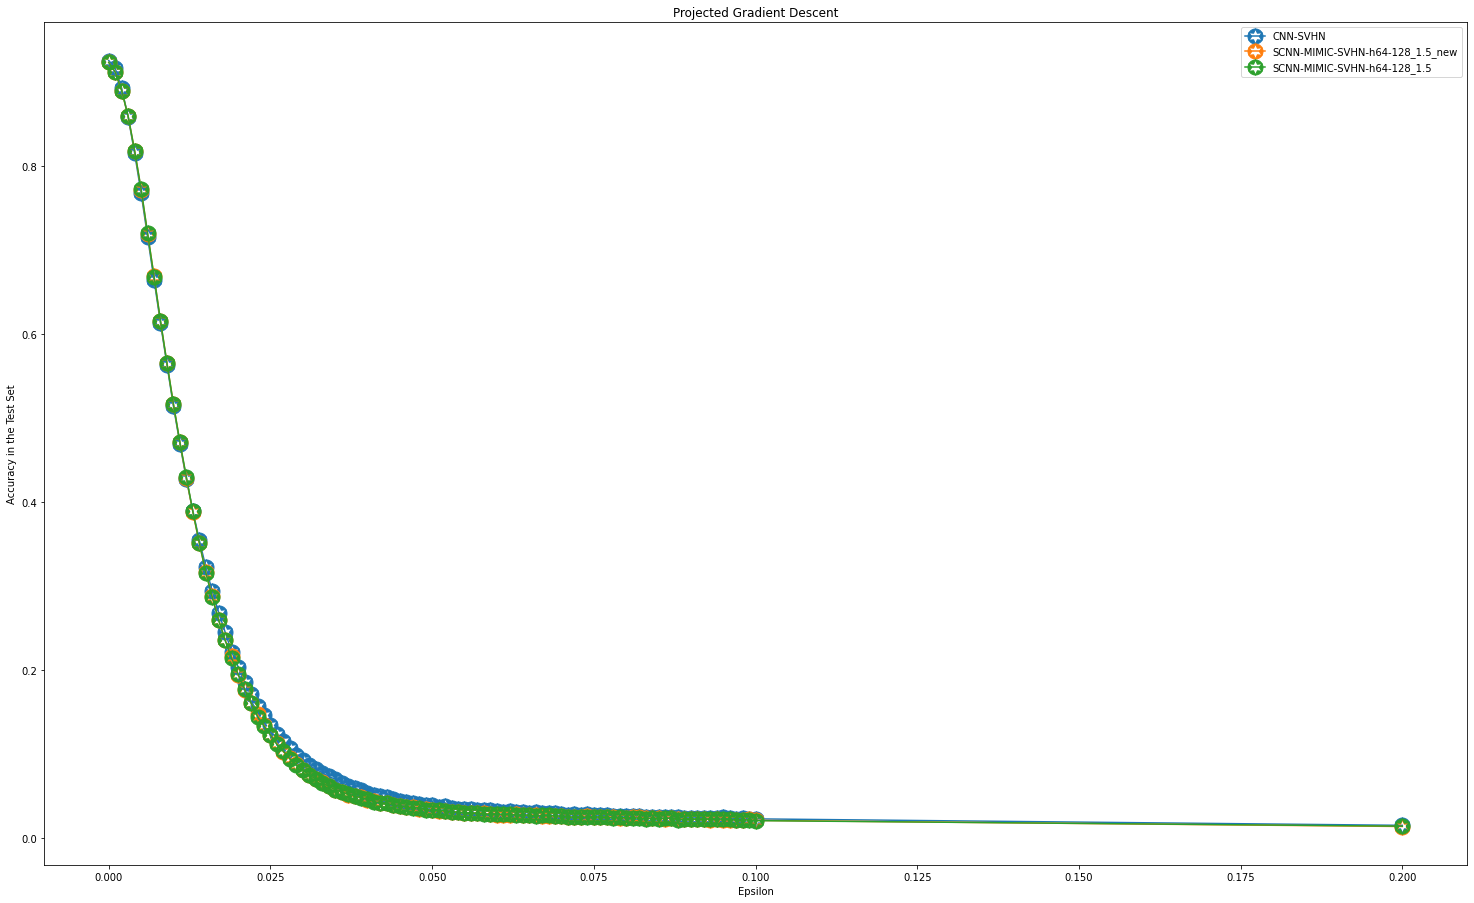

In [ ]:
import matplotlib.path as mpath
import numpy as np

star = mpath.Path.unit_regular_star(6)
circle = mpath.Path.unit_circle()
# concatenate the circle with an internal cutout of the star
verts = np.concatenate([circle.vertices, star.vertices[::-1, ...]])
codes = np.concatenate([circle.codes, star.codes])
cut_star = mpath.Path(verts, codes)

fig = plt.figure()
fig.set_size_inches(25.5, 15.5)

plt.plot(epsilon_values_teacher_pgd , epsilon_accuracies_teacher_pgd , label='CNN-SVHN', marker=cut_star, markersize=15)
plt.plot(epsilon_values_student_pgd , epsilon_accuracies_student_pgd , label='SCNN-MIMIC-SVHN-h64-128_1.5_new', marker=cut_star, markersize=15)
plt.plot(epsilon_values_student_pgd_nonprune , epsilon_accuracies_student_pgd_nonprune , label='SCNN-MIMIC-SVHN-h64-128_1.5', marker=cut_star, markersize=15)


plt.title('Projected Gradient Descent')
plt.xlabel('Epsilon');
plt.ylabel('Accuracy in the Test Set');
plt.legend()
plt.show()

In [ ]:
epsilon_accuracies_teacher_pgd=[0.9252842664718628, 0.9160648584365845, 0.8921711444854736, 0.858059287071228, 0.8149585127830505, 0.7675937414169312, 0.715657651424408, 0.6645282506942749, 0.6129763126373291, 0.5633835196495056, 0.5140212178230286,0.46953749656677246, 0.42716655135154724, 0.3897126615047455, 0.354755699634552]

epsilon_values_teacher_pgd=[0.0, 0.001, 0.002, 0.003, 0.004, 0.005, 0.006, 0.007, 0.008, 0.009000000000000001, 0.01,0.011, 0.012, 0.013000000000000001, 0.014]
epsilon_accuracies_student_pgd=[0.9230562448501587, 0.9116856455802917, 0.8895590305328369, 0.858712375164032, 0.8180316686630249, 0.7718192934989929, 0.7193838357925415, 0.6691763997077942, 0.615050733089447, 0.5654963254928589, 0.5164797306060791,0.4712277054786682, 0.42835739254951477, 0.38859865069389343, 0.3509911000728607]

epsilon_values_student_pgd=[0.0, 0.001, 0.002, 0.003, 0.004, 0.005, 0.006, 0.007, 0.008, 0.009000000000000001, 0.01,0.011, 0.012, 0.013000000000000001, 0.014]

epsilon_accuracies_student_pgd_nonprune=[0.9230562448501587, 0.9114551544189453, 0.8893285393714905, 0.8589428663253784, 0.8181468844413757, 0.7726644277572632, 0.7201905250549316, 0.6682928800582886, 0.615818977355957, 0.5652273893356323, 0.5168254375457764,0.4712277054786682, 0.4301244616508484, 0.38890597224235535, 0.35179778933525085]
epsilon_values_student_pgd_nonprune=[0.0, 0.001, 0.002, 0.003, 0.004, 0.005, 0.006, 0.007, 0.008, 0.009000000000000001, 0.01,0.011, 0.012, 0.013000000000000001, 0.014]

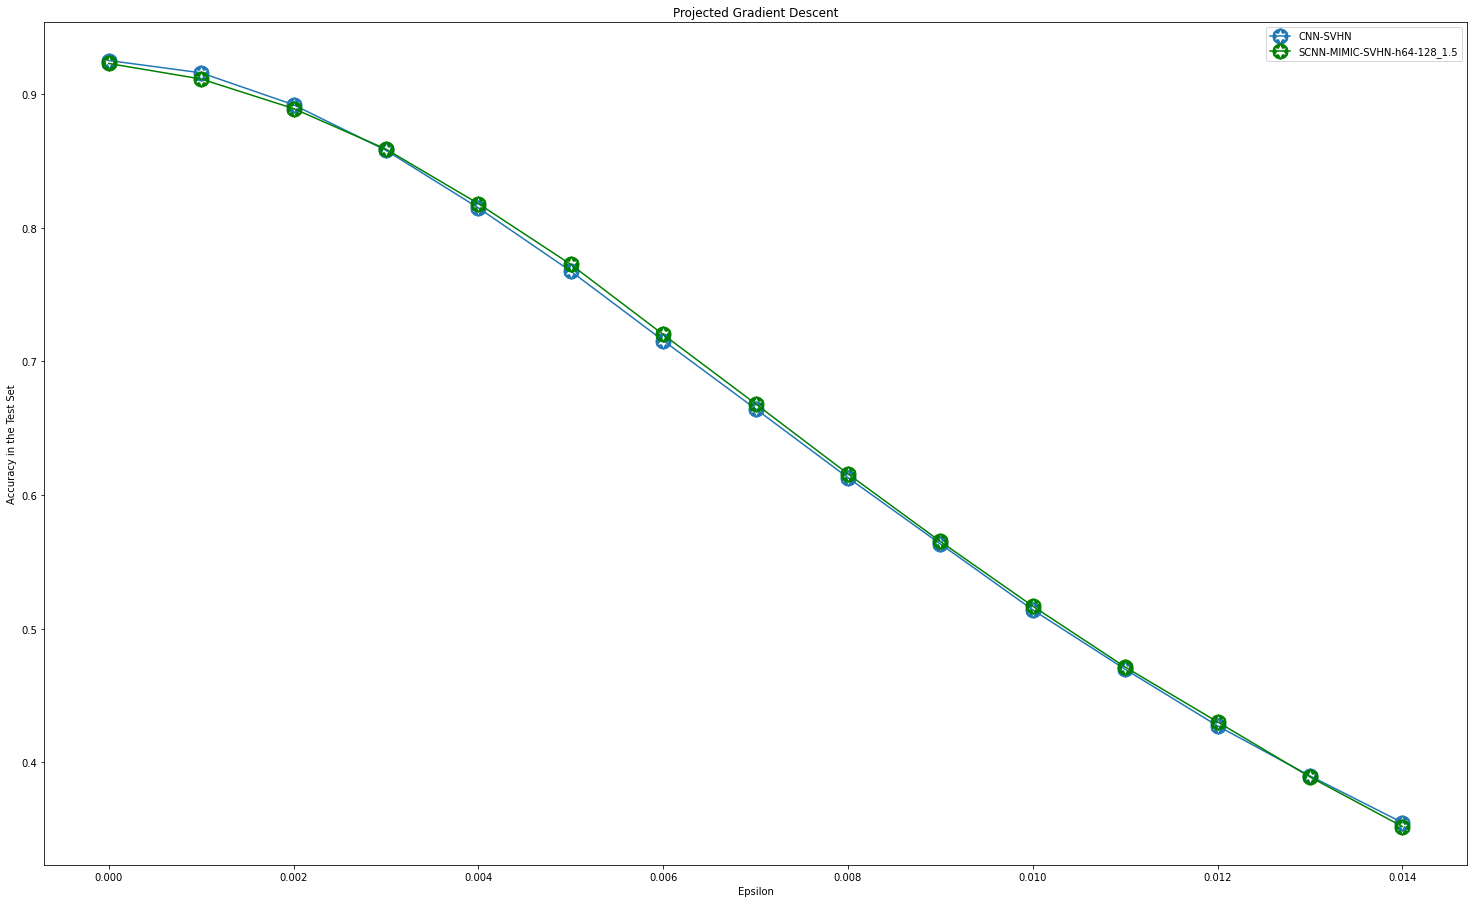

In [ ]:
import matplotlib.path as mpath
import numpy as np

star = mpath.Path.unit_regular_star(6)
circle = mpath.Path.unit_circle()
# concatenate the circle with an internal cutout of the star
verts = np.concatenate([circle.vertices, star.vertices[::-1, ...]])
codes = np.concatenate([circle.codes, star.codes])
cut_star = mpath.Path(verts, codes)

fig = plt.figure()
fig.set_size_inches(25.5, 15.5)

plt.plot(epsilon_values_teacher_pgd , epsilon_accuracies_teacher_pgd , label='CNN-SVHN', marker=cut_star, markersize=15)
plt.plot(epsilon_values_student_pgd_nonprune , epsilon_accuracies_student_pgd_nonprune , label='SCNN-MIMIC-SVHN-h64-128_1.5', marker=cut_star, markersize=15, color='green')

plt.title('Projected Gradient Descent')
plt.xlabel('Epsilon');
plt.ylabel('Accuracy in the Test Set');
plt.legend()
plt.show()

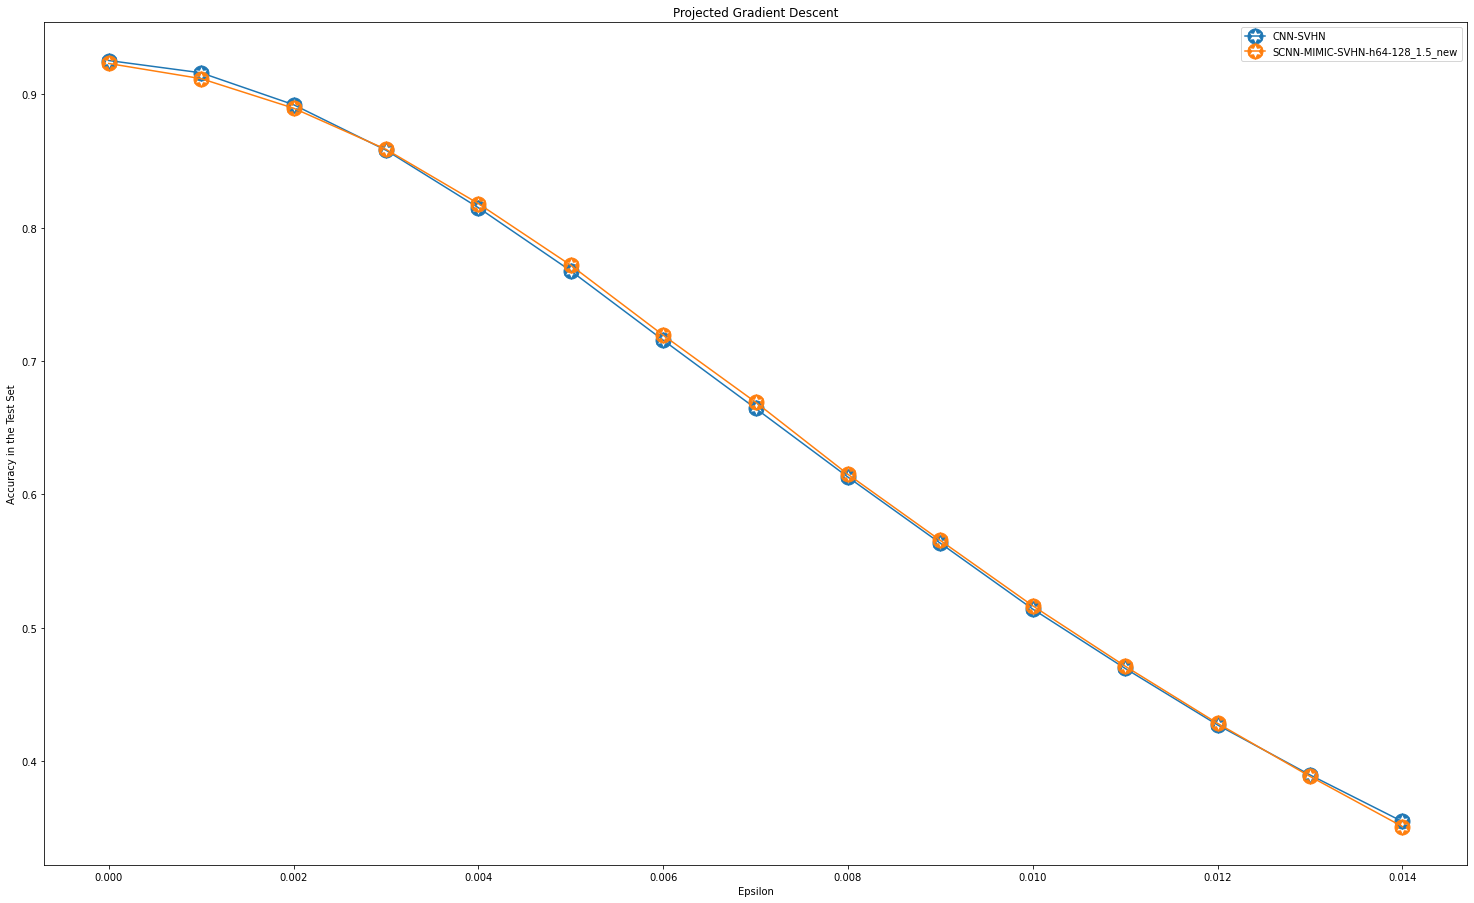

In [ ]:
import matplotlib.path as mpath
import numpy as np

star = mpath.Path.unit_regular_star(6)
circle = mpath.Path.unit_circle()
# concatenate the circle with an internal cutout of the star
verts = np.concatenate([circle.vertices, star.vertices[::-1, ...]])
codes = np.concatenate([circle.codes, star.codes])
cut_star = mpath.Path(verts, codes)

fig = plt.figure()
fig.set_size_inches(25.5, 15.5)

plt.plot(epsilon_values_teacher_pgd , epsilon_accuracies_teacher_pgd , label='CNN-SVHN', marker=cut_star, markersize=15)
plt.plot(epsilon_values_student_pgd , epsilon_accuracies_student_pgd , label='SCNN-MIMIC-SVHN-h64-128_1.5_new', marker=cut_star, markersize=15)

plt.title('Projected Gradient Descent')
plt.xlabel('Epsilon');
plt.ylabel('Accuracy in the Test Set');
plt.legend()
plt.show()

In [ ]:
epsilon_accuracies_teacher_pgd=[0.3230639100074768, 0.29383066296577454, 0.26859250664711, 0.24523663520812988, 0.22222648561000824, 0.20401813089847565, 0.1864244043827057, 0.17167332768440247, 0.15795943140983582, 0.14674247801303864, 0.13475722074508667, 0.1244237869977951, 0.11581899225711823, 0.1079440712928772, 0.09972342103719711, 0.09361554682254791, 0.08689305186271667, 0.0821681022644043, 0.07824984937906265, 0.07360172271728516, 0.0704517513513565, 0.06630301475524902, 0.06273048371076584, 0.05950368940830231, 0.05708358809351921, 0.054240934550762177, 0.051206208765506744, 0.04982329532504082, 0.04874769598245621, 0.04636600986123085, 0.044637370854616165, 0.043561771512031555, 0.04237092658877373, 0.04114167019724846, 0.03964351490139961, 0.03918254375457764]
epsilon_values_teacher_pgd=[0.015, 0.016, 0.017, 0.018000000000000002, 0.019, 0.02,0.021, 0.022, 0.023, 0.024, 0.025, 0.026000000000000002, 0.027, 0.028, 0.029, 0.03, 0.031, 0.032, 0.033, 0.034, 0.035, 0.036000000000000004, 0.037, 0.038, 0.039, 0.04, 0.041, 0.042, 0.043000000000000003, 0.044, 0.045, 0.046, 0.047, 0.048, 0.049, 0.05]

epsilon_accuracies_student_pgd=[0.31718653440475464, 0.28795328736305237, 0.2599108815193176, 0.2360556274652481, 0.21669483184814453, 0.19472187757492065, 0.17701290547847748, 0.16072526574134827, 0.14735710620880127, 0.1346803903579712, 0.12292563170194626, 0.11293791979551315, 0.10298863053321838, 0.09511370956897736, 0.08800707012414932, 0.08132299035787582, 0.07556084543466568, 0.07022126764059067, 0.06703288108110428, 0.061808545142412186, 0.05808236077427864, 0.05497080460190773, 0.05208973586559296, 0.050053779035806656, 0.04886293783783913, 0.045789796859025955, 0.04406115412712097, 0.04237092658877373, 0.041641056537628174, 0.04002765938639641, 0.038337431848049164, 0.03756914660334587, 0.03680086135864258, 0.034841734915971756, 0.03445759043097496, 0.03372772037982941]
epsilon_values_student_pgd=[0.015, 0.016, 0.017, 0.018000000000000002, 0.019, 0.02,0.021, 0.022, 0.023, 0.024, 0.025, 0.026000000000000002, 0.027, 0.028, 0.029, 0.03, 0.031, 0.032, 0.033, 0.034, 0.035, 0.036000000000000004, 0.037, 0.038, 0.039, 0.04, 0.041, 0.042, 0.043000000000000003, 0.044, 0.045, 0.046, 0.047, 0.048, 0.049, 0.05]

epsilon_accuracies_student_pgd_nonprune=[0.3160725235939026, 0.28676244616508484, 0.25918102264404297, 0.23540258407592773, 0.2143515646457672, 0.19518284499645233, 0.17720498144626617, 0.16110940277576447, 0.14493699371814728, 0.13383528590202332, 0.12292563170194626, 0.11167025566101074, 0.10360325872898102, 0.0947679802775383, 0.08704671263694763, 0.08136139810085297, 0.07552243024110794, 0.07037492096424103, 0.06641825288534164, 0.06173171475529671, 0.05789028853178024, 0.05527811869978905, 0.052358634769916534, 0.05086047947406769, 0.04824830964207649, 0.046826981008052826, 0.043523356318473816, 0.04229409992694855, 0.04179471358656883, 0.039413031190633774, 0.03887522965669632, 0.037223417311906815, 0.03637830540537834, 0.03622464835643768, 0.03426551818847656, 0.03349723294377327]

epsilon_values_student_pgd_nonprune=[0.015, 0.016, 0.017, 0.018000000000000002, 0.019, 0.02,0.021, 0.022, 0.023, 0.024, 0.025, 0.026000000000000002, 0.027, 0.028, 0.029, 0.03, 0.031, 0.032, 0.033, 0.034, 0.035, 0.036000000000000004, 0.037, 0.038, 0.039, 0.04, 0.041, 0.042, 0.043000000000000003, 0.044, 0.045, 0.046, 0.047, 0.048, 0.049, 0.05]


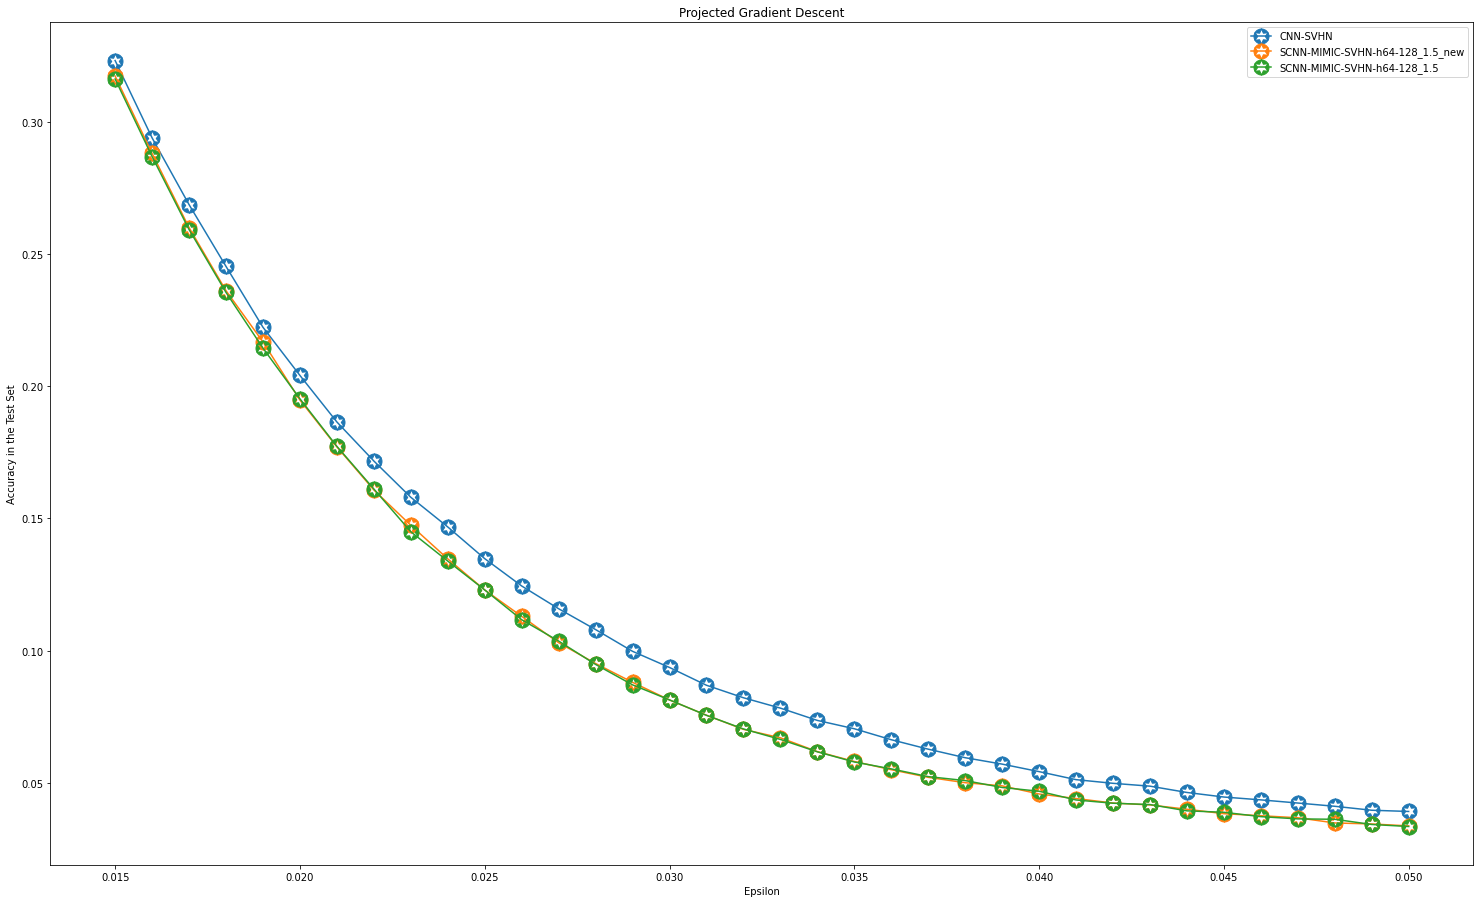

In [ ]:
import matplotlib.path as mpath
import numpy as np

star = mpath.Path.unit_regular_star(6)
circle = mpath.Path.unit_circle()
# concatenate the circle with an internal cutout of the star
verts = np.concatenate([circle.vertices, star.vertices[::-1, ...]])
codes = np.concatenate([circle.codes, star.codes])
cut_star = mpath.Path(verts, codes)

fig = plt.figure()
fig.set_size_inches(25.5, 15.5)

plt.plot(epsilon_values_teacher_pgd , epsilon_accuracies_teacher_pgd , label='CNN-SVHN', marker=cut_star, markersize=15)
plt.plot(epsilon_values_student_pgd , epsilon_accuracies_student_pgd , label='SCNN-MIMIC-SVHN-h64-128_1.5_new', marker=cut_star, markersize=15)
plt.plot(epsilon_values_student_pgd_nonprune , epsilon_accuracies_student_pgd_nonprune , label='SCNN-MIMIC-SVHN-h64-128_1.5', marker=cut_star, markersize=15)

plt.title('Projected Gradient Descent')
plt.xlabel('Epsilon');
plt.ylabel('Accuracy in the Test Set');
plt.legend()
plt.show()

### Momentum Iterative Method

In [ ]:
epsilon_accuracies_student_mim  = [0.9230562448501587, 0.5021896362304688, 0.18096958100795746, 0.07394745200872421, 0.042562998831272125, 0.03272894769906998, 0.028925936669111252, 0.02692839503288269, 0.025353411212563515, 0.024354640394449234, 0.02366318367421627, 0.016979102045297623]
epsilon_accuracies_teacher_mim= [0.9252842664718628, 0.5033804774284363, 0.19199447333812714, 0.08685464411973953, 0.050322677940130234, 0.037185002118349075, 0.0324600487947464, 0.029502151533961296, 0.027466194704174995, 0.02600645273923874, 0.025238167494535446, 0.01824677363038063]
epsilon_values_teacher_mim = [0.0, 0.01, 0.02, 0.03, 0.04, 0.05, 0.06, 0.07, 0.08, 0.09, 0.1, 0.2]
epsilon_values_student_mim = [0.0, 0.01, 0.02, 0.03, 0.04, 0.05, 0.06, 0.07, 0.08, 0.09, 0.1, 0.2]


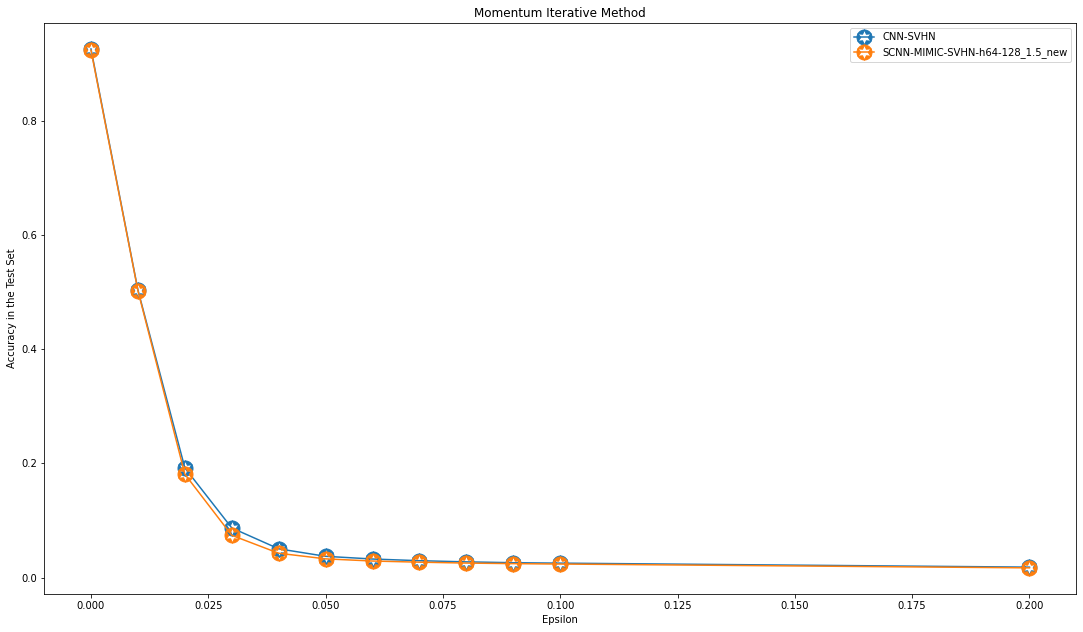

In [ ]:
import matplotlib.path as mpath
import numpy as np

star = mpath.Path.unit_regular_star(6)
circle = mpath.Path.unit_circle()
# concatenate the circle with an internal cutout of the star
verts = np.concatenate([circle.vertices, star.vertices[::-1, ...]])
codes = np.concatenate([circle.codes, star.codes])
cut_star = mpath.Path(verts, codes)

fig = plt.figure()
fig.set_size_inches(18.5, 10.5)

plt.plot(epsilon_values_teacher_mim, epsilon_accuracies_teacher_mim, label='CNN-SVHN', marker=cut_star, markersize=15)
plt.plot(epsilon_values_student_mim, epsilon_accuracies_student_mim, label='SCNN-MIMIC-SVHN-h64-128_1.5_new', marker=cut_star, markersize=15)

plt.title('Momentum Iterative Method')
plt.xlabel('Epsilon');
plt.ylabel('Accuracy in the Test Set');
plt.legend()
plt.show()